In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import linregress

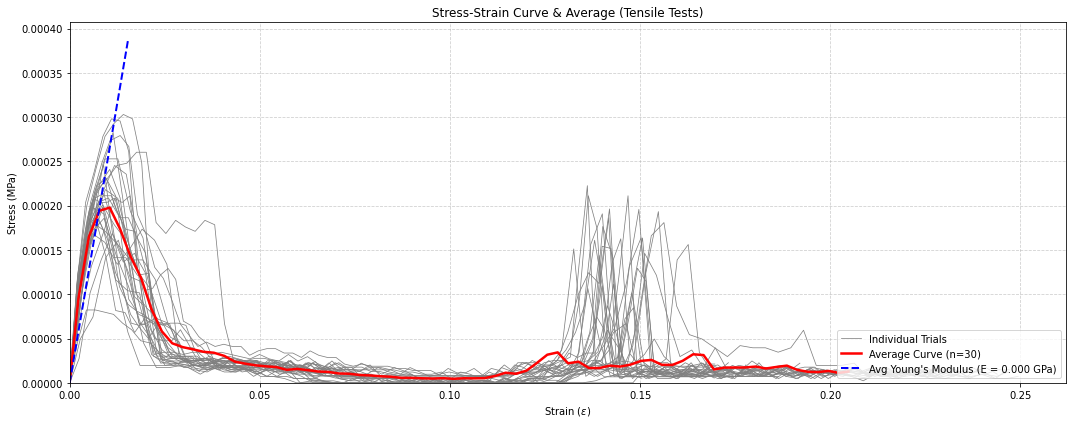

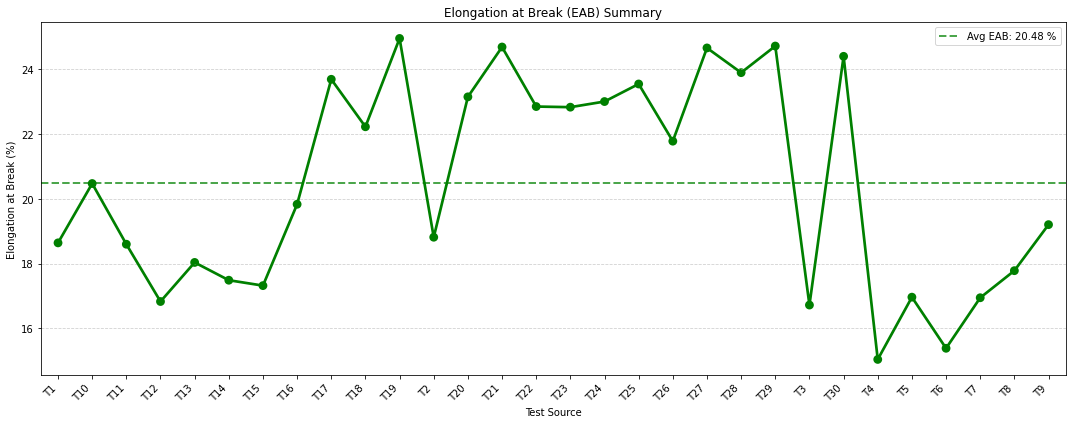

In [3]:
# TE Fins

#Material Constants
A0_MM2 = 40500      
L0_MM = 150         
E_STRAIN_LIMIT = 0.0075
MIN_FORCE_FILTER = 0.1 
FILE_PATH = 'TE Fins mUTM.xlsx'
MIN_POINTS_REQUIRED = 4

TITLE_SS = 'Stress-Strain Curve & Average (Tensile Tests)'
TITLE_E = "Young's Modulus (E) Summary"
TITLE_EAB = 'Elongation at Break (EAB) Summary'
COLOR_INDIVIDUAL = 'grey'
COLOR_AVERAGE = 'red'
COLOR_MODULUS = 'blue'
COLOR_EAB = 'green'

try:
    all_sheets_data = pd.read_excel(FILE_PATH, sheet_name=None)
except FileNotFoundError:
    exit()

combined_data = pd.DataFrame()
for sheet_name, df in all_sheets_data.items():
    df['Test_Source'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

combined_data['Stress_MPa'] = combined_data['Force_N'] / A0_MM2
combined_data['Strain'] = combined_data['Displacement_mm'] / L0_MM
combined_data['Stress_MPa_Raw'] = combined_data['Stress_MPa'].copy()

grouped_curves = combined_data.groupby('Test_Source')

metrics_results = []

for name, group in grouped_curves:
    elastic_region_data = group[
        (group['Strain'] <= E_STRAIN_LIMIT) &
        (group['Force_N'] > MIN_FORCE_FILTER)
    ].dropna(subset=['Strain', 'Stress_MPa'])

    E_value = float('nan')
    if len(elastic_region_data) >= MIN_POINTS_REQUIRED:
        slope, _, _, _, _ = linregress(elastic_region_data['Strain'], elastic_region_data['Stress_MPa'])
        E_value = slope

    max_strain = group['Strain'].max()
    EAB_value = max_strain * 100

    metrics_results.append({
        'Test_Source': name,
        'Young_Modulus_MPa': E_value,
        'Young_Modulus_GPa': E_value / 1000,
        'Elongation_at_Break_pct': EAB_value
    })

df_metrics_summary = pd.DataFrame(metrics_results)

e_values_mpa = df_metrics_summary['Young_Modulus_MPa'].tolist()
valid_e_values = [e for e in e_values_mpa if not np.isnan(e)]
avg_E_MPa = np.mean(valid_e_values) if valid_e_values else float('nan')
avg_E_GPa = avg_E_MPa / 1000

avg_EAB = df_metrics_summary['Elongation_at_Break_pct'].mean()

min_valid_len = float('inf')
valid_groups = []
for name, group in grouped_curves:
    clean_group = group.dropna(subset=['Strain', 'Stress_MPa'])
    current_len = len(clean_group)
    if current_len >= MIN_POINTS_REQUIRED:
        if current_len < min_valid_len:
            min_valid_len = current_len
        valid_groups.append((name, clean_group))

strs_curves = []
strn_curves = []
num_avgd = 0

if min_valid_len != float('inf'):
    for _, clean_group in valid_groups:
        strs_curves.append(clean_group['Stress_MPa'].values[:min_valid_len])
        strn_curves.append(clean_group['Strain'].values[:min_valid_len])

    strs_matrix = np.array(strs_curves)
    strn_matrix = np.array(strn_curves)

    avg_strs = np.mean(strs_matrix, axis=0)
    avg_strn = np.mean(strn_matrix, axis=0)
    num_avgd = strs_matrix.shape[0]
else:
    exit()

plt.figure(figsize=(15, 6))

valid_tests_count = 0
for name, group in grouped_curves:
    clean_group = group.dropna(subset=['Strain', 'Stress_MPa'])
    if len(clean_group) >= MIN_POINTS_REQUIRED:
        plt.plot(
            clean_group['Strain'],
            clean_group['Stress_MPa'],
            color=COLOR_INDIVIDUAL,
            linewidth=0.75,
            label='Individual Trials' if valid_tests_count == 0 else "_nolegend_"
        )
        valid_tests_count += 1

avg_label = f'Average Curve (n={num_avgd})'
plt.plot(avg_strn, avg_strs, color=COLOR_AVERAGE, linewidth=2.5, label=avg_label)

# Plot Young's Modulus Line
if not np.isnan(avg_E_MPa):
    E_line_strn = np.linspace(0, avg_strn.max() * 0.075, 50)
    E_line_strs = avg_E_MPa * E_line_strn

    modulus_label = f"Avg Young's Modulus (E = {avg_E_GPa:.3f} GPa)"
    plt.plot(
        E_line_strn, E_line_strs,
        color=COLOR_MODULUS, linestyle='--', linewidth=2.0,
        label=modulus_label
    )

plt.title(TITLE_SS)
plt.xlabel('Strain ($\epsilon$)')
plt.ylabel('Stress (MPa)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
if not df_metrics_summary.empty:
    sns.pointplot(
        x='Test_Source',
        y='Elongation_at_Break_pct',
        data=df_metrics_summary,
        color=COLOR_EAB,
        errorbar=None,
        capsize=0.1
    )
    plt.axhline(
        avg_EAB,
        color=COLOR_EAB,
        linestyle='--',
        linewidth=2,
        alpha=0.7,
        label=f'Avg EAB: {avg_EAB:.2f} %'
    )
    plt.title(TITLE_EAB)
    plt.xlabel('Test Source')
    plt.ylabel('Elongation at Break (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    exit()

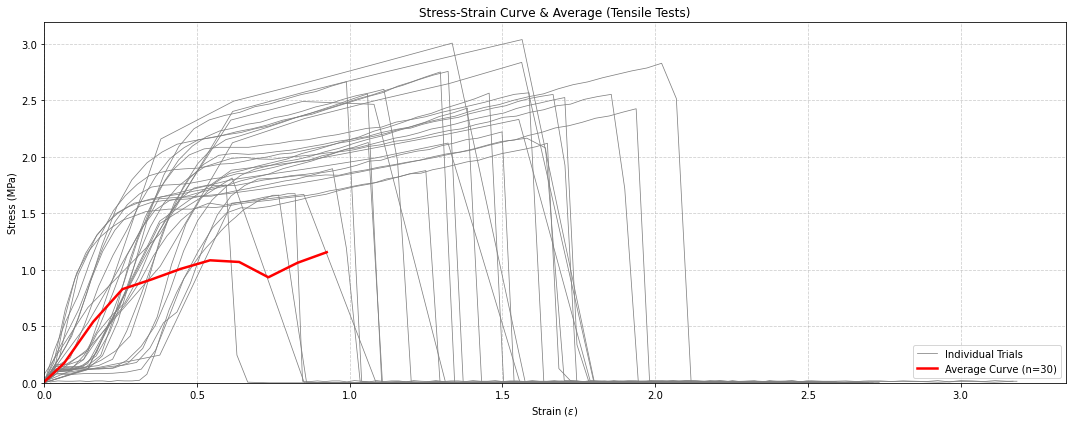

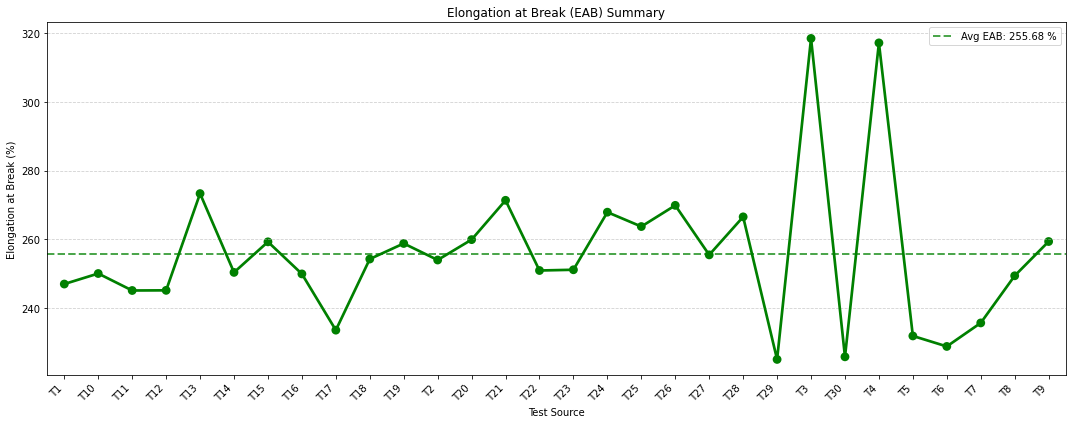

In [17]:
# Polyimide Film

#Material Constants
A0_MM2 = 36      
L0_MM = 12         
E_STRAIN_LIMIT = 0.001
MIN_FORCE_FILTER = 0.0001 
FILE_PATH = 'Polyimide mUTM.xlsx'
MIN_POINTS_REQUIRED = 4

TITLE_SS = 'Stress-Strain Curve & Average (Tensile Tests)'
TITLE_E = "Young's Modulus (E) Summary"
TITLE_EAB = 'Elongation at Break (EAB) Summary'
COLOR_INDIVIDUAL = 'grey'
COLOR_AVERAGE = 'red'
COLOR_MODULUS = 'blue'
COLOR_EAB = 'green'

try:
    all_sheets_data = pd.read_excel(FILE_PATH, sheet_name=None)
except FileNotFoundError:
    exit()

combined_data = pd.DataFrame()
for sheet_name, df in all_sheets_data.items():
    df['Test_Source'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

combined_data['Stress_MPa'] = combined_data['Force_N'] / A0_MM2
combined_data['Strain'] = combined_data['Displacement_mm'] / L0_MM
combined_data['Stress_MPa_Raw'] = combined_data['Stress_MPa'].copy()

grouped_curves = combined_data.groupby('Test_Source')

metrics_results = []

for name, group in grouped_curves:
    elastic_region_data = group[
        (group['Strain'] <= E_STRAIN_LIMIT) &
        (group['Force_N'] > MIN_FORCE_FILTER)
    ].dropna(subset=['Strain', 'Stress_MPa'])

    E_value = float('nan')
    if len(elastic_region_data) >= MIN_POINTS_REQUIRED:
        slope, _, _, _, _ = linregress(elastic_region_data['Strain'], elastic_region_data['Stress_MPa'])
        E_value = slope

    max_strain = group['Strain'].max()
    EAB_value = max_strain * 100

    metrics_results.append({
        'Test_Source': name,
        'Young_Modulus_MPa': E_value,
        'Young_Modulus_GPa': E_value / 1000,
        'Elongation_at_Break_pct': EAB_value
    })

df_metrics_summary = pd.DataFrame(metrics_results)

e_values_mpa = df_metrics_summary['Young_Modulus_MPa'].tolist()
valid_e_values = [e for e in e_values_mpa if not np.isnan(e)]
avg_E_MPa = np.mean(valid_e_values) if valid_e_values else float('nan')
avg_E_GPa = avg_E_MPa / 1000

avg_EAB = df_metrics_summary['Elongation_at_Break_pct'].mean()

min_valid_len = float('inf')
valid_groups = []
for name, group in grouped_curves:
    clean_group = group.dropna(subset=['Strain', 'Stress_MPa'])
    current_len = len(clean_group)
    if current_len >= MIN_POINTS_REQUIRED:
        if current_len < min_valid_len:
            min_valid_len = current_len
        valid_groups.append((name, clean_group))

strs_curves = []
strn_curves = []
num_avgd = 0

if min_valid_len != float('inf'):
    for _, clean_group in valid_groups:
        strs_curves.append(clean_group['Stress_MPa'].values[:min_valid_len])
        strn_curves.append(clean_group['Strain'].values[:min_valid_len])

    strs_matrix = np.array(strs_curves)
    strn_matrix = np.array(strn_curves)

    avg_strs = np.mean(strs_matrix, axis=0)
    avg_strn = np.mean(strn_matrix, axis=0)
    num_avgd = strs_matrix.shape[0]
else:
    exit()

plt.figure(figsize=(15, 6))

valid_tests_count = 0
for name, group in grouped_curves:
    clean_group = group.dropna(subset=['Strain', 'Stress_MPa'])
    if len(clean_group) >= MIN_POINTS_REQUIRED:
        plt.plot(
            clean_group['Strain'],
            clean_group['Stress_MPa'],
            color=COLOR_INDIVIDUAL,
            linewidth=0.75,
            label='Individual Trials' if valid_tests_count == 0 else "_nolegend_"
        )
        valid_tests_count += 1

avg_label = f'Average Curve (n={num_avgd})'
plt.plot(avg_strn, avg_strs, color=COLOR_AVERAGE, linewidth=2.5, label=avg_label)

# Plot Young's Modulus Line
if not np.isnan(avg_E_MPa):
    E_line_strn = np.linspace(0, avg_strn.max(), 50)
    E_line_strs = avg_E_MPa * E_line_strn

    modulus_label = f"Avg Young's Modulus (E = {avg_E_GPa:.3f} GPa)"
    plt.plot(
        E_line_strn, E_line_strs,
        color=COLOR_MODULUS, linestyle='--', linewidth=2.0,
        label=modulus_label
    )

plt.title(TITLE_SS)
plt.xlabel('Strain ($\epsilon$)')
plt.ylabel('Stress (MPa)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
if not df_metrics_summary.empty:
    sns.pointplot(
        x='Test_Source',
        y='Elongation_at_Break_pct',
        data=df_metrics_summary,
        color=COLOR_EAB,
        errorbar=None,
        capsize=0.1
    )
    plt.axhline(
        avg_EAB,
        color=COLOR_EAB,
        linestyle='--',
        linewidth=2,
        alpha=0.7,
        label=f'Avg EAB: {avg_EAB:.2f} %'
    )
    plt.title(TITLE_EAB)
    plt.xlabel('Test Source')
    plt.ylabel('Elongation at Break (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    exit()